# Prosjekt 2 teknisk fysikk, Gruppenr: 9070

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time


%matplotlib inline

#parametre
sigma = 500     #kg/m^2     massetetthet til skipet per lengdeenhet
sigma0 = 1000   #kg/m^2     massetetthet til vann per lengdeenehet 
R = 10          #m
As = 0.5 * np.pi * R**2 #m^2
I_C = 0.5* As * sigma * R**2 * (1- 32 / (9*np.pi**2))

m = As * sigma  #massen til skipet

#konstanter
g = 9.81
h = 4*R/(3*np.pi)

## $\textbf{Hvorfor sank Vasa?}$

### $\textbf{1 Innledning}$

Den 10. august 1628 forliste det svenske Vasaskipet på sin jomfrutur. Hele seansen varte i kun 20 minutter, og har siden blitt stående som en ingeniørtabbe av de sjeldne. Vasa skulle være et flaggskip for det svenske militæret med sine 47.5 meter og 2 kanondekk, men endte heller på 32 meters dyp. Med utgangspunkt i denne hendelsen vil det være svært interessant å undersøke hvilke krefter som faktisk påvirker dynamikken og stabiliteten til et skip på havet. Vi vil i dette prosjektet derfor studere en forenklet skipsmodell som utsettes for diverse krefter ute på åpen sjø. For å realisere dette har vi programmert funksjoner som kan løse sammensatte ordinære differensiallikninger. Her er det Eulers metode og RK4 som primært har blitt tatt i bruk. Gjennom prosjektet har vi gradvis bygget opp koden til å ta hensyn til flere og flere mulige bidragsytere til skipets stabilitet, som en storm som gradvis bygger seg opp på åpent hav. Rapporten vil først ta for seg selve skipsmodellen og kreftene den utsettes for. Deretter presenteres resultater fra de ulike simuleringene som har blitt utført gjennom oppgaven. 

### $\textbf{2 Skipsmodell}$

For enkelhets skyld ser vi her på et langt halvsirkelformet skip med radius $R$. Skipet er kompakt med en konstand massetetthet lik $\sigma$ og $\lambda$ henholdsvis per flateenhet og i lengderetning. For en slik kompakt halvsirkel vil massesenteret ligge i en avstand $d = \frac{4R}{3\pi}$ fra metasenteret $M$, som er lokalisert midt på skipsdekket. 

For å beregne skipets oppdrift vil det være nyttig å ta i bruk skipets sektorvinkel $\gamma$, som angir hvor stor del av halvsirkelbuen som ligger under vann. For å finne sektorvinkelen $\beta$ i likevekt, må vi løse likningen

$$f(\beta) = \beta - \sin(\beta) - \frac{\pi \sigma}{\sigma_0} = 0$$

hvor $\sigma_0$ er massetettheten til vann (se oppgavetekst). For å løse denne likningen numerisk kan den skrives om til fikspunklikningen 

$$ \beta - \sin(\beta) = \frac{\pi \sigma}{\sigma_0} \implies \beta =  \frac{\pi \sigma}{\sigma_0} + \sin(\beta) = g(\beta)$$

Denne likningen løser vi ved å bruke fikspunktiterasjoner

$$\beta_{k+1} = g(\beta_k)$$


Men hvordan vet vi at fikspunktiterasjon vil gi oss et riktig svar i dette tilfellet? Vi ser på intervallet $\beta \in \left[\epsilon, \pi-\epsilon \right]$ for en tilstrekkelig liten $\epsilon>0 $ og . Vi studerer dette intervalelt siden for 0 grader er ikke båten nede i vannet og for 180 grader er båten fullstendig under vann. Videre har vi at $\epsilon < g(\beta) < \pi-\epsilon$ for alle $\beta \in \left[\epsilon, \pi-\epsilon \right]$ slik at $g(\left[\epsilon, \pi-\epsilon \right]) \subset (\epsilon, \pi-\epsilon)$. Videre er $g'(\beta) = \cos(\beta) \implies \lvert g'(\beta) \rvert < 1$ for alle $\beta \in \left[\epsilon, \pi-\epsilon \right]$. Ved fikspunktteoremet vil dermed $g$ ha en unik rot $r\in \left[\epsilon, \pi - \epsilon \right]$, og fikspunktiterasjoner $\beta_{k+1} = g(\beta_k)$ konvergerer mot roten r for alle startveriden $\beta_0 \in \left[ \epsilon, \pi-\epsilon \right]$.

Dette utføres i funksjonen **solve_fixedpoint()**. I tillegg til å ta inn den opprinnelige likningen og fikspunktlikningen, tar funksjonen inn en maksgrense på antall iterasjoner og en toleranse. Førstnevnte gjør at funksjonen ikke kjører evig hvis det viser seg at problemet vårt ikke kan løses med fikspunktiterasjon. Sistnevnte gir oss muligheten til å velge hvor nærme den faktiske løsningen vi ønsker å være. 

I dette tilfellet har vi satt maks antall iterasjoner $maxit = 10^3$ og $tol = 10^{-8}$. Funksjonen bruker 44 iterasjoner og gir ut en $\beta \approx 2.30988 rad$. 



In [2]:
#the function we are going to solve
def f_3(x):
    return x - np.sin(x) - np.pi * sigma / sigma0

#the step function or g(beta)
def f_3_step(x):
    return np.pi *sigma / sigma0 + np.sin(x)

#function that solves fixpoint equations
def solve_fixedpoint(f,f_step, x0,tol = 1.e-8, maxit = 1.e+3):
    xk = x0
    it = 0
    
    while it < maxit:
        if abs(f(xk)) <= tol:
            return xk, it

        xk = f_step(xk)
        it += 1

    print(f"Error: reached maximum allowed steps")
    return xk, it

#solved for the equilibrium angle beta
beta, it = solve_fixedpoint(f_3,f_3_step,1)
print(f"Antall iterasjoner brukt er it = {it}")
print(f"Løsningen på fikspunktlikningen er beta = {beta} radianer og beta = {beta*180 / np.pi} grader")

Antall iterasjoner brukt er it = 44
Løsningen på fikspunktlikningen er beta = 2.309881455617707 radianer og beta = 132.3464585824298 grader


For videre beregninger er det essensielt å ha posisjonen til skipets metasenter, skipets massesenter, skipets dypeste punkt og angrepspunktet for oppdriften. Disse er ved likevekt gitt under. Merk at $R=10$ selv om dette ikke er det faktiske tilfellet for Vasaskipet. $y=0$ ligger på vannoverflaten.  

- skipets metasenter: 
$$y_M^0 = R \cos(\frac{\beta}{2}) \implies y_M^0 = 4.04m$$
- skipets massesenter: 
$$y_C^0 = R \cos(\frac{\beta}{2}) - \frac{4 R}{ 3 \pi} \implies y_C^0=-0.204m$$
- skipets dypeste punkt:
$$y_D^0 = R \cos(\frac{\beta}{2}) - R \implies y_D^0 = -5.96m$$
- angrepspunktet til oppdriftskraften
$$y_B^0 =  R \cos(\frac{\beta}{2}) - \frac{4R \sin^3(\frac{\beta}{2})}{3 (\beta - \sin(\beta))} \implies y_B^0 = -2.46m$$

Under har vi plottet den aktuelle skipsmodellen (med seil) i likevekt sammen med punktene beskrevet over $\textbf{Figur 1}$. 

YM0 = 4.039727553085146 m, YC0 = -0.2044042626987297 m, YD0 = -5.960272446914854 m, YB0 = -2.457918494562139 m


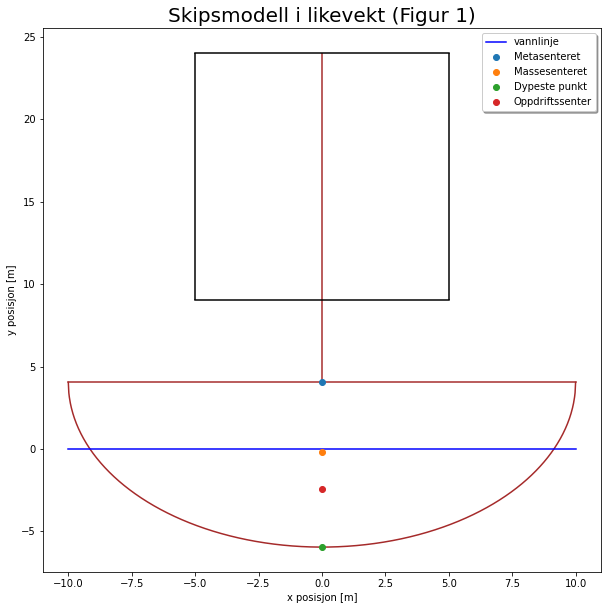

In [3]:
#likevekts punktene
yM_0 = R*np.cos(beta/2)
yC_0 = R*np.cos(beta/2) - 4*R / (3*np.pi)
yD_0 = R*np.cos(beta/2) - R
yB_0 = R*np.cos(beta/2) - 4 * R * (np.sin(beta/2))**3 / (3 * (beta - np.sin(beta)))

print(f"YM0 = {yM_0} m, YC0 = {yC_0} m, YD0 = {yD_0} m, YB0 = {yB_0} m")

x_circ = np.linspace(-R,R,1000)

plt.figure(figsize = (10,10))
plt.title('Skipsmodell i likevekt (Figur 1)', fontsize=20)
#båten
plt.plot(x_circ, yM_0*np.ones(len(x_circ)), 'brown')
plt.plot(x_circ, -np.sqrt(R**2 - x_circ**2) + yM_0, 'brown')
plt.vlines([0.0], yM_0, yM_0 + 2*R, colors='brown', linestyles='solid')
plt.plot(x_circ[250:750], np.ones(500)* (yM_0 + 2*R), 'black')
plt.plot(x_circ[250:750], np.ones(500)* (yM_0 + 2*R- 15), 'black')
plt.vlines([x_circ[250]], yM_0+ 2*R-15, yM_0 + 2*R, colors='black', linestyles='solid')
plt.vlines([x_circ[750]], yM_0 + 2*R-15, yM_0 + 2*R, colors='black', linestyles='solid')


#vannlinja
plt.plot(x_circ, np.zeros(len(x_circ)), 'b', label = 'vannlinje')

#de ulike punktene
plt.plot(0, yM_0, 'o',label = "Metasenteret")
plt.plot(0,yC_0, 'o',label = "Massesenteret")
plt.plot(0, yD_0, 'o',label = "Dypeste punkt")
plt.plot(0, yB_0, 'o',label = "Oppdriftssenter")


plt.xlabel('x posisjon [m]')
plt.ylabel('y posisjon [m]')
plt.legend(fancybox = True, shadow = True)
plt.show()

Når vi legger til last vil vi måtte beregne startverdiene til $\beta, y_C, \cdots$ på nytt. Vi antar at den massen vi legger til er er en punktmasse, det vil si at lasten kun bidrar med masse og ikke noe areal. Dermed trenger vi kun å endre massetettheten til båten for å regne ut disse verdiene. Den nye massetettheten til båten $\sigma_L$ blir

$\sigma_L = \sigma + \frac{m_L}{A_S}$

In [4]:
#må finne nye verdier for [beta, yc] osv når vi legger til last
#returnerer [beta, A0, yC0, yM0, yD0, yB0]
def initVals_last(mL):
    sigma_L = sigma + mL / As
    g = lambda beta: np.pi * sigma_L / sigma0 + np.sin(beta)
    f = lambda beta: beta - g(beta)

    beta, it = solve_fixedpoint(f,g,1)

    yM_0 = R*np.cos(beta/2)
    yC_0 = R*np.cos(beta/2) - 4*R / (3*np.pi)
    yD_0 = R*np.cos(beta/2) - R
    yB_0 = R*np.cos(beta/2) - 4 * R * (np.sin(beta/2))**3 / (3 * (beta - np.sin(beta)))

    A0 = 0.5* R**2 *(beta- np.sin(beta))

    return [beta, A0,yC_0, yM_0, yD_0,yB_0]


### $\textbf{3 Krefter}$

Kreftene som vikrker på skipet er som følger: 

Gravitasjon $F_G$ (y-reting):
- **(14a)** $F_G = - m g$
- Gravitasjonskraften angriper i massesenteret $C$. 

Oppdrift $F_B$ (y-retning): 
- **(14b)** $F_B = A \sigma_0 g$
- Oppdriften angrpier i oppdriftsenteret $B$, og genererer følgende dreiemoment: 
    - **(15a)** $\tau_B = - F_B h \sin(\theta)$

Friksjon $f$ (x-retning): 
- **(14c)** $f = -k_f R \gamma \omega$
- Friksjonskraften angriper i dypeste punkt og genererer følgende dreiemoment: 
    - **(15b)** $\tau_f = f(y_C - (R(cos(\gamma/2) - 1)))$

Vind og bølger $F_w$ (x-retning): 
- **(14d)** $F_w = F_0 cos \omega_w t$
- Kraften fra vind og bølger angriper i høyde med vannlinjen og genererer følgende dreiemoment: 
    - **(15c)** $\tau_w = F_w y_C$
- Som en ser er dette en harmonisk kraft med amplitude $F_0$ og vinkelfrekvens $\omega_w$. 

Bevegelig last $F_L$:
- **(14e)** $F_L^y = - m_L g \cos^2{\theta}$
- **(14f)** $F_L^x = m_L g \cos{\theta} \sin{\theta}$
- **(14e)** og **(14f)** beskriver kontaktkraften mellom lasten og skipet i henholdsvis y og x-retning, og genererer følgende dreiemoment: 
    - **(15d)** = $m_L g cos(\theta) s_L$
- Her er $m_L$ og $s_L$ henholdsvis massen og posisjonen til lasten. 

Når vi videre i dette prosjektet introduserer nye krefter til systemet vil vi referere til likningene gitt i denne delen. 

### $\textbf{4 ODE-løseren}$

Det er **ODE_solver()** sin jobb å løse de aktuelle differensiallikningene i dette prosjektet. Det det er her vesentlig å sette opp denne funksjonen på en måte som gjør at den kan løse alle våre ønskede problemer, og at dette kun avhenger av hva funksjonen tar som inputvariabler. For å realisere dette tar løseren inn 3 bool-variabler som gjør at vi kan bestemme om vi skal gi skipet last, gjerder og muligheten til å kantre. 

**ODE_solver()** skal løse følgende andre ordens differensiallikninger: 

- **(12)** $\sum F = m A = m \frac{\partial V}{\partial t} = m \frac{\partial ^2 R}{\partial t^2}$ 

- **(13)** $\sum \tau = I_C \frac{\partial \omega}{\partial t}$

 

In [5]:
def ODE_solver(f,t0,tend, y0, h, method, mL = 0, check_kantre = False, check_last = False, fence = False):
    t_vals = np.array([t0])
    t = t0
    
    y_vals = np.array([y0])
    cur_y = y0

    #control of iterations
    it = 0

    #estimate for total iterations. Uniform distributed points. 
    N = (tend-t0) / h

    #variabel som sjekker om lasten har falt av
    has_fallen = False


    #finner likevektsverdiene til systemet
    initVals = initVals_last(mL)
    beta = initVals[0]
    A0 = initVals[1]
    yC_0 = initVals[2]


    while tend - t > 1.e-10:
        #We always will include the last point tend.
        if t + h > tend:
            h = tend- t

        #calculates the new step given a method
        t += h

        cur_y = method(f, t, cur_y, h, mL)

        #sjekker hvis båten har kantra
        if check_kantre:
            gamma = 2 * np.arccos(np.cos(beta/2) - 4/(3 * np.pi) * (1 - np.cos(cur_y[0])) + (cur_y[2] - yC_0) / R)
            if cur_y[0] > (np.pi - gamma) / 2:
                print()

                print(f"Skipet har kantret ved t = {t}")

                #setter alle verdiene lik 0, utenom theta som er lik +- pi/2

                n = np.shape(cur_y)[0]

                cur_vec = np.zeros((1,n))
                cur_vec[0][0] = cur_y[0]

                sgn = cur_y[0] / abs(cur_y[0])

                y_vals = np.concatenate((y_vals, cur_vec))
                t_vals = np.append(t_vals,t)

                while tend - t > 1.e-10:
                    if t + h > tend:
                        h = tend-t
                    
                    t += h

                    cur_vec = np.zeros((1,n))
                    cur_vec[0][0] = sgn * np.pi/2

                    t_vals = np.append(t_vals, t)
                    y_vals = np.concatenate((y_vals, cur_vec))
                    
                break

            #sjekker om lasten har falt dersom vi har last
            if check_last:
                #lasten har falt av dersom abs sL > R
                if abs(cur_y[6]) > R:
                    #gjerde gjør at den ikke faller av
                    if fence:
                        cur_y[6] = R * cur_y[6] / abs(cur_y[6])
                        cur_y[7] = 0

                    #dersom det ikke er gjerde faller ikke lasten av
                    else:
                        cur_y[6] = (R+1) * cur_y[6] / abs(cur_y[6])
                        cur_y[7] = 0
                        mL = 0

                        #beregner likevektsverdiene på nytt, men nå uten last
                        if not has_fallen:
                            initVals = initVals_last(mL)
                            beta = initVals[0]
                            A0 = initVals[1]
                            yC_0 = initVals[2]

                            has_fallen = True
                            
                    

        #adds the new step
        y_vals = np.concatenate((y_vals, np.array([cur_y])))
        t_vals = np.append(t_vals, t)

       
        it += 1


    return t_vals, y_vals



### $\textbf{5 Eulers metode}$

Vi skal først ta i bruk eulers metode for å se på det enkleste tilfellet for skipsmodellens dynamikk. Her ser vi kun på kreftene gitt i likning **(14a)** og **(14b)**. Vi neglisjerer også bevegelsene til skipets massesenter, og antar at mengden fortrengt vann er konstant. Dette medfører at $|F_G|=|F_B|$, som betyr at det kun er oppdriftens dreiemoment om skipets massesenter som kan påvirke dynamikken i systemet.  


Med disse ankagelsene vil vi kunne skrive likning **(13)** som $\sum \tau = \tau_B = I_C \frac{\partial \omega}{\partial t} \implies \frac{\partial \omega}{\partial t} = \frac{\tau_B}{I_C}$. Videre er det oppgitt at $\frac{\partial \theta}{\partial t} = \omega$.

Vi introduserer nå vektoren $\vec{\omega} = \left[\begin{array}{c} \theta(t) \\ \omega(t)  \end{array}\right]$. Videre finner vi $\frac{\partial \vec{\omega}}{\partial t} = \vec{f}(t, \vec{\omega}) =  \left[\begin{array}{c} \frac{\partial \theta}{\partial t} \\ \frac{\partial \omega}{\partial t}  \end{array}\right] = \left[\begin{array}{c} \omega \\ \frac{-F_B h \sin(\theta)}{I_C}  \end{array}\right] $ 

Vi bruker $A = A_0 = \frac{1}{2} R^2 (\beta - \sin(\beta)) \implies F_B = \frac{1}{2} R^2 (\beta - \sin(\beta)) \sigma_0 g$

Med eulers metode ønsker vi å finne $\vec{\omega}(t + h)$, hvor $h$ er en gitt steglengde. Taylorutvikling av dette gir $$\vec{\omega}(t + h) = \vec{\omega}(t) + h\vec{\omega}'(t) + \frac{1}{2}h^2\vec{\omega}''(t) + ...$$

Hvis vi nå velger en liten steglengde $h$, vil vi komme frem til følgende approksimasjon: 

$$\vec{\omega}(t + h) \approx \vec{\omega}(t) + h\vec{\omega}'(t)$$

Dette er Eulers metode. I første omgang skal vi altså løse differensiallikningen gitt over. Her setter vi $\theta_0 = 20^{\circ}$, $\omega_0 = 0$ og $h=0.001$ og måler bevegelsene til systemet fra $t=0$ til $t=20s$. Resultatet er plottet i $\textbf{Figur 2}$, hvor både vinkelen $\theta$ og vinkelhastigheten $\omega$ inngår i plottet. Plottet viser hvordan skipet fungerer som en fysisk pendel under disse omstendighetene.  

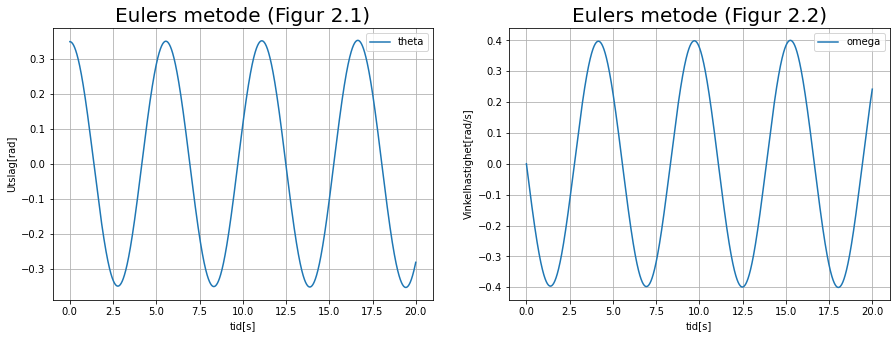

In [6]:
A0 = 0.5* R**2 *(beta- np.sin(beta))
F_B = A0*sigma0 * g

def f(t, omega_vec, mL = 0):
    theta = omega_vec[0]
    omega = omega_vec[1]

    return np.array([omega, -F_B * h * np.sin(theta) / I_C])


#a step in the euler method
def euler_method(f,t,y, h, mL):
    return y + h * f(t,y)

omega_0 = np.array([0.349,0])
t0 = 0
tend = 20


t_vals, omega_vals = ODE_solver(f,t0,tend,omega_0,1.e-3,euler_method)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(t_vals,omega_vals[:,0], label='theta')
plt.title('Eulers metode (Figur 2.1)', fontsize=20)
plt.ylabel('Utslag[rad]')
plt.xlabel('tid[s]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_vals,omega_vals[:,1], label='omega')
plt.title('Eulers metode (Figur 2.2)', fontsize=20)
plt.ylabel('Vinkelhastighet[rad/s]')
plt.xlabel('tid[s]')
plt.legend()
plt.grid(True)


plt.show()

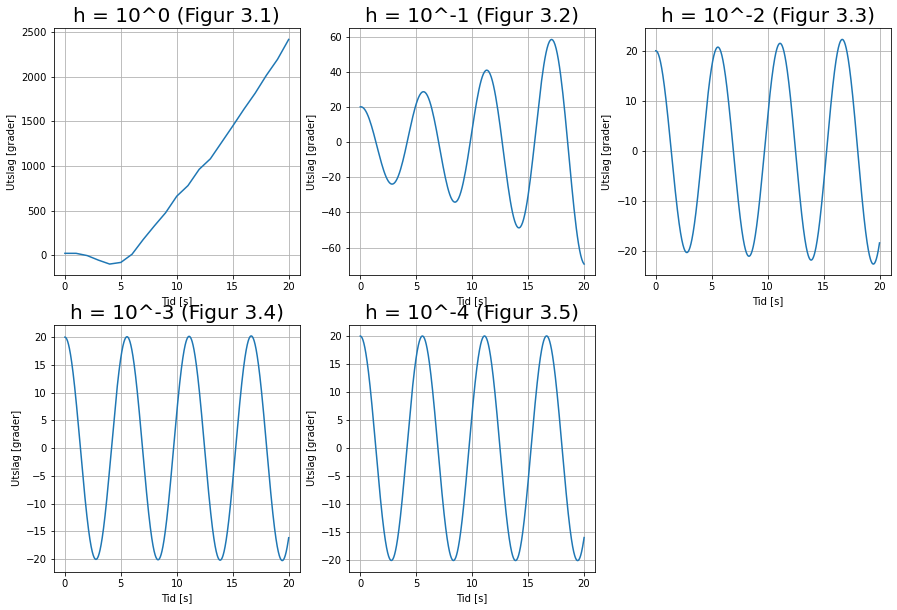

In [7]:
#initial values
omega_0 = np.array([0.349,0])
t0 = 0
tend = 20

#h = 10^-0
t_vals_0, y_vals_0 = ODE_solver(f,t0, tend,omega_0,1.e-0, euler_method)
#h = 10^-1
t_vals_1, y_vals_1 = ODE_solver(f,t0, tend,omega_0,1.e-1, euler_method)
#h = 10^-2
t_vals_2, y_vals_2 = ODE_solver(f,t0, tend,omega_0,1.e-2, euler_method)
#h = 10^-3
t_vals_3, y_vals_3 = ODE_solver(f,t0, tend,omega_0,1.e-3, euler_method)
#h = 10^-4
t_vals_4, y_vals_4 = ODE_solver(f,t0, tend,omega_0,1.e-4, euler_method)

y_vals_0 *= 180/np.pi
y_vals_1 *= 180/np.pi
y_vals_2 *= 180/np.pi
y_vals_3 *= 180/np.pi
y_vals_4 *= 180/np.pi


#plot the function with different h values
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.title("h = 10^0 (Figur 3.1)", fontsize = 15)
plt.ylabel("Utslag [grader]")
plt.xlabel("Tid [s]")
plt.plot(t_vals_0, y_vals_0[:,0])
plt.grid(True)

plt.subplot(2,3,2)
plt.title("h = 10^-1 (Figur 3.2)", fontsize=15)
plt.ylabel("Utslag [grader]")
plt.xlabel("Tid [s]")
plt.plot(t_vals_1, y_vals_1[:,0])
plt.grid(True)

plt.subplot(2,3,3)
plt.title("h = 10^-2 (Figur 3.3)", fontsize=15)
plt.ylabel("Utslag [grader]")
plt.xlabel("Tid [s]")
plt.plot(t_vals_2, y_vals_2[:,0])
plt.grid(True)

plt.subplot(2,3,4)
plt.title("h = 10^-3 (Figur 3.4)", fontsize=15)
plt.ylabel("Utslag [grader]")
plt.xlabel("Tid [s]")
plt.plot(t_vals_3, y_vals_3[:,0])
plt.grid(True)

plt.subplot(2,3,5)
plt.title("h = 10^-4 (Figur 3.5)", fontsize=20)
plt.ylabel("Utslag [grader]")
plt.xlabel("Tid [s]")
plt.plot(t_vals_4, y_vals_4[:,0])
plt.grid(True)

plt.show()

Figuren over $\textbf{(Figur 3)}$ viser at store skrittlengder h ødelegger løsningen. For $h \leq 10^{-3}$ ser vi at vi får bedre resultater. Det ser ikke ut til at vinkelen øker med tiden, som det gjør for $h \geq 10^{-2}$. En plausibel forklaring for hvorfor vinkelen øker med tiden for store h er på grunn av følgefeil, og at den ikke klarer å få med seg alle detaljene. Videre vil det ta lenger tid å kjøre jo lavere h verdien er. For $h = 10^{-3}$ er kjøretiden kort og den gir greie resultater. Derfor velger vi å bruke denne videre.


For $\theta \ll 1$ kan vi approksimere $\sin(\theta) \approx \theta$. Slår vi sammen likning **13** og **15a**, og bruker de samme antagelsene som ovenfor og småvinkel approksimasjonen vil vi kunne skrive den andreordens differensial likningen for $\theta$ på formen

$$\frac{\partial^2 \theta}{\partial t^2} + \frac{F_B h}{I_C} \theta = 0$$

Denne likningen løser vi også ved hjelp av Eulers metode: 

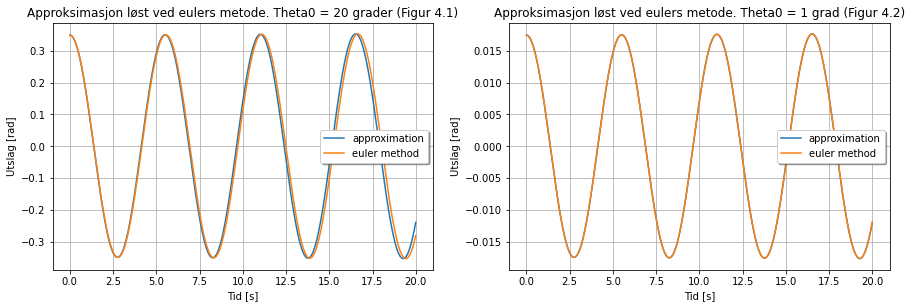

In [8]:
omega_0_20 = np.array([20*np.pi/180,0])
omega_0_1 = np.array([1*np.pi/180,0])
t0 = 0
tend = 20

def f_approx(t, omega_vec, mL = 0):
    theta = omega_vec[0]
    omega = omega_vec[1]

    return np.array([omega, -F_B * h * theta / I_C])

t_approx_20, y_approx_20 = ODE_solver(f_approx,t0,tend,omega_0_20,1.e-3, method = euler_method)
t_vals_3_20, y_vals_3_20 = ODE_solver(f, t0, tend, omega_0_20, 1.e-3, method = euler_method)

t_approx_1, y_approx_1 = ODE_solver(f_approx,t0,tend,omega_0_1,1.e-3, euler_method)
t_vals_3_1, y_vals_3_1 = ODE_solver(f,t0,tend,omega_0_1,1.e-3, euler_method)


plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.title("Approksimasjon løst ved eulers metode. Theta0 = 20 grader (Figur 4.1)")
plt.xlabel("Tid [s]")
plt.ylabel("Utslag [rad]")
plt.plot(t_approx_20, y_approx_20[:,0], label = "approximation")
plt.plot(t_vals_3_20, y_vals_3_20[:,0], label = "euler method")
plt.legend(fancybox = True, shadow = True)
plt.grid(True)


plt.subplot(2,2,2)
plt.title("Approksimasjon løst ved eulers metode. Theta0 = 1 grad (Figur 4.2)")
plt.xlabel("Tid [s]")
plt.ylabel("Utslag [rad]")
plt.plot(t_approx_1, y_approx_1[:,0], label = "approximation")
plt.plot(t_vals_3_1,y_vals_3_1[:,0], label = "euler method")
plt.legend(fancybox = True, shadow = True)
plt.grid(True)
plt.show()

I figuren over $\textbf{(Figur 4)}$ er det plottet løsningen av differensial likningen med småvinkel approksimasjonen $\sin{\theta} \approx \theta$, og uten denne approksimasjonen for en gitt startvinkel $\theta_0$. I plottet til venstre er $\theta_0 = 20^{\circ}$, og det er mulig å se at løsningen med småvinkel approksimasjonen kommer ut av fase, og vil ikke lenger ligge oppå løsningen uten denne approksimasjonen.I motsetning vil løsningen med småvinkel approksimasjonen ligge oppå løsningen uten denne approksimasjonen i plottet til høyre. Her er startvinkelen $\theta_0 = 1^{\circ}$. 

Dette sier oss at småvinkel approksimasjonen fungerer bedre for småvinkler sånn som $1^{\circ}$ enn større vinkler som $20^{\circ}$. Dette er et rimelig resultat hvis man ser på taylor utviklingen til $sin{\theta} = \theta - \frac{\theta^3}{3!} + \cdots$. For små vinkler $\theta$ vil $\theta^3$ være veldig lite og det vil være greit å se bort ifra.

### $\textbf{6 Runge-Kutta 4 metoden}$
En annen metode for å løse systemer av ordinære differensiallikninger på er Runge-Kutta 4 metoden. Dette er en metode av orden fire som vil si at den globale feilen etter N steg og med en steglengde på $h = \frac{x_{end}- x_0}{N}$ er mindre eller lik $e_N \leq Ch^4$. Til sammenlikning er euler metoden av orden 1. Videre er metoden en eksplisitt metode, samme som euler metoden, som vil si at den kun bruker verdier som er regnet ut tidligere og vi slipper å løse likninger som er en tidkrevende operasjon.

Metoden er defintert ved:
- $k_1 = \vec{f}(t_i, \vec{\omega_i})$
- $k_2 = \vec{f}(t_i + \frac{h}{2}, \vec{\omega_i} + h \frac{k_1}{2})$
- $k_3 = \vec{f}(t_i + \frac{h}{2}, \vec{\omega_i}+ h \frac{k_2}{2})$
- $k_4 = \vec{f}(t_i + h, \vec{\omega_i} + h k_3)$

$\vec{\omega_{i+1}} = \vec{\omega_i} + \frac{h}{6} (k_1 + 2 k_2 + 2 k_3 + k_4)$

Butcher-tableux for Runge-kutta 4 metoden er
$$
\begin{array}{c|cccc}
      0 & 0 & 0 & 0 & 0\\ \frac{1}{2} &  \frac{1}{2} & 0 & 0 & 0\\ \frac{1}{2} & 0 & \frac{1}{2} & 0 & 0\\ 1 &  0 & 0 & 1 & 0 \\ \hline & \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}  
    \end{array}
$$

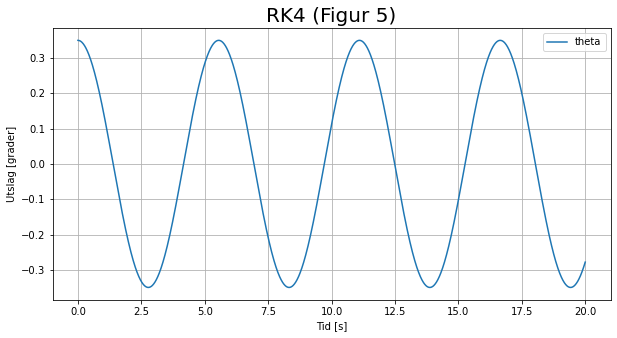

In [9]:
def rk4_method(f, t, y, h, mL):
    k1 = f(t, y, mL)
    k2 = f(t + h/2, y + h*k1/2, mL)
    k3 = f(t + h/2, y + h*k2/2, mL)
    k4 = f(t + h, y + h*k3, mL)

    return y +  h/6*(k1 + 2*k2 + 2*k3 + k4)

omega_0_20 = np.array([20*np.pi/180,0])
t0 = 0
tend = 20

t_vals, y_vals = ODE_solver(f,t0,tend,omega_0_20,0.01, rk4_method)


plt.figure(figsize=(10,5))
plt.title('RK4 (Figur 5)', fontsize = 20)
plt.xlabel("Tid [s]")
plt.ylabel("Utslag [grader]")
plt.plot(t_vals, y_vals[:,0], label = "theta")
plt.legend()
plt.grid(True)
plt.show()

I $\textbf{Figur 5}$ har vi plottet løsningen på den samme differensiallikningen som vi løste i $\textbf{Figur 2}$, men nå med RK4 som løsningsmetode. Utifra de to figurene er det vaskelig å se noe forskjell mellom de to metodene for dette problemet. Men ettersom eulers metode og RK4 er av henholdsvis orden 1 og 4, forventer vi å finne forskjeller i hvordan metodene avviker fra den analytiske løsningen for ulike steglengder. 

For små vinkler $\theta \ll 1$ vil vi kunne bruke approksimasjonen $\sin{\theta} \approx \theta$, og differensiallikningen vår vil ha den analytiske løsningen: 

$$\tilde{\theta}(t) = A \cos(\sqrt{{\frac{F_B h}{I_c}}} t + \phi)$$

For initialveridene $\theta_0 = 0.01$ rad og $\omega_0 = 0$ rad/s blir den analytiske løsningen: 

$$\tilde{\theta}(t) = 0.01 \cos(\sqrt{{\frac{F_B h}{I_c}}} t)$$

Videre skal vi sammenlikne hvoran feilen til de to metodene avviker fra den analytiske approksimasjonen $\tilde{\theta}(t)$ som en funksjon av steglengden $h$. 


### $\textbf{7 Feilestimering}$

In [10]:
t0 = 0
tend = 20

h_vals = np.arange(1.e-3,1.e-1, 1.e-3)

omega_0 = np.array([0.01,0])
diff_rk4 = np.zeros(len(h_vals))
diff_euler = np.zeros(len(h_vals))



for i in range(len(h_vals)):
    t_vals, omega_rk4 = ODE_solver(f_approx,t0,tend,omega_0, h_vals[i], rk4_method) 
    t_vals, omega_euler = ODE_solver(f_approx,t0,tend,omega_0,h_vals[i], euler_method)
    theta_approx = 0.01 * np.cos(np.sqrt(F_B*h/I_C) * t_vals[-1])

    diff_rk4[i] = abs(omega_rk4[-1][0] - theta_approx)
    diff_euler[i] = abs(omega_euler[-1][0] - theta_approx)



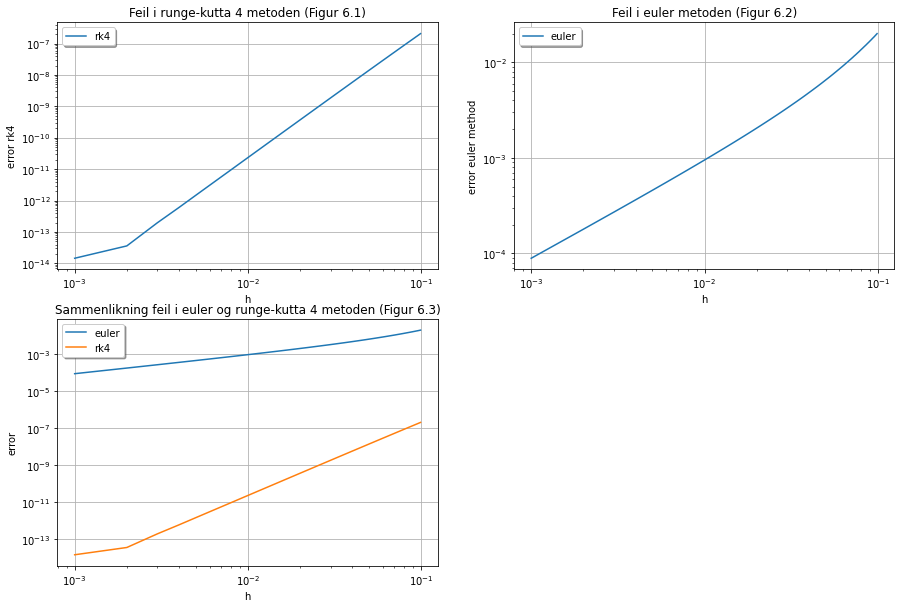

Runge-kutta 4 metoden er av orden p ≈ 3.8955
Euler metoden er av orden p ≈ 1.2302


In [11]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.title("Feil i runge-kutta 4 metoden (Figur 6.1)")
plt.ylabel("error rk4")
plt.xlabel("h")
plt.xscale('log')
plt.yscale('log')
plt.plot(h_vals, diff_rk4, label = "rk4")
plt.grid(True)
plt.legend(fancybox = True, shadow = True)

plt.subplot(2,2,2)
plt.title("Feil i euler metoden (Figur 6.2)")
plt.ylabel("error euler method")
plt.xlabel("h")
plt.xscale('log')
plt.yscale('log')
plt.plot(h_vals, diff_euler, label = "euler")
plt.grid(True)
plt.legend(fancybox = True, shadow = True)

plt.subplot(2,2,3)
plt.title("Sammenlikning feil i euler og runge-kutta 4 metoden (Figur 6.3)")
plt.ylabel("error")
plt.xlabel("h")
plt.xscale('log')
plt.yscale('log')
plt.plot(h_vals, diff_euler, label = "euler")
plt.plot(h_vals, diff_rk4, label = "rk4")
plt.grid(True)
plt.legend(fancybox = True, shadow = True)


plt.show()


#finner stigningstallet til linjene, dette vil være det samme som ordenen p
def objective(x,a,b):
    return a*x + b

curve_fit_euler, _ = curve_fit(objective, np.log10(h_vals), np.log10(diff_euler))

curve_fit_rk4, _ = curve_fit(objective, np.log10(h_vals), np.log10(diff_rk4))

print(f"Runge-kutta 4 metoden er av orden p ≈ {round(curve_fit_rk4[0],4)}")
print(f"Euler metoden er av orden p ≈ {round(curve_fit_euler[0],4)}")

Den globale feilen til en metode er definert ved $\lvert e_n \rvert = \lvert y(x_{end}) - y_N\rvert \leq C h^{p}$ for en metode av orden p, der det er tatt N steg for å nå $x_{end}$ ved bruk av den konstante steglengden $h = \frac{x_{end} - x_0}{N}$. Her er $y(x_{end})$ den faktiske analytiske verdien i $x = x{end}$, $y_N$ er approksimasjonen etter N steg ved bruk av metoden og $C$ er en konstant. Denne feilen har vi plottet ovenfor $\textbf{(Figur 6)}$, for både runge-kutta 4 metoden og euler metoden. I plottene har vi tatt logaritmen av begge aksene.

En kan observere at feilen for runge-kutta 4 metoden er lavere enn feilen for euler metoden for alle steglengder h, som er et forventet resultat da ordenen til runge-kutta 4 metoden er 4 og euler metoden er 1. Videre kan en observere at vi har en lineær sammenheng i plottene, og stigningstallet a til denne linja vil være ordenen p til metoden:

$$a = \frac{log(e_N(h^{m})) - log(e_n(h^{m+1}))}{log(h^m) - log(h^{m+1})} = \frac{log(Ch^{pm}) - log(Ch^{p(m+1)})}{log(h^m) - log(h^{m+1})}  = \frac{log(\frac{Ch^{pm}}{Ch^{p(m+1)}})}{log(\frac{h^m}{h^{m+1}})} = \frac{-p log(h)}{-log(h)} = p \implies a = p$$

 Vi har fått at ordenen til runge-kutta 4 metoden er $p\approx 3.8955$ og at ordenen til euler metoden er $p \approx 1.2302$. Dette avviker litt fra de teoretiske ordenene til metodene.



For runge-kutta 4 metoden flater $e_N$ ut for lave h. Her vil feilen ligge rundt $10^{-13}$. En mulig faktor til at linja flates ut er avrundings feil. Dette kommer av at datamaskinen ikke kan ha uendelige mange desimaler, og for flyttall i python vil det forekomme avrundingsfeil når man nærmer seg en størrelsesorden på $10^{-15}$, i flytall brukes det generelet 53 bits for representerere det signifikante sifferet dette svarer til en presisjon på cirka 15 siffer. Når man ganger med så lav h vil man altså bare få med seg de 2 siste sifferne.. Siden linja flatet ut er det ikke urimelig at vi fikk et stigningstall som er litt under den faktiske ordenen til runge-kutta 4 metoden.

For euler-metoden ser vi at feilen vil vokse raskere for større steglengder. Vi har med steglengder opp til $h = 10^{-1}$. Tidligere har vi sett at euler metoden er svært dårlig for så store steglengder som $h = 10^{-1}$, og at approksimasjonen ikke ser ut som løsnignen. Det er derfor ikke urimelig at vi får en orden som er litt høyere enn den teoretiske.

### $\textbf{8 Translasjon}$

Videre kommer denne oppgaven til å bruke RK4 med mindre noe annet blir spesifisert. Vi er nå klare til å utvide modellen vår, og begynner med å forkaste antagelsen om at massesenterets bevegelse kan neglisjeres. Dermed blir **(12)** og **(13)** koblede differensiallikninger, og vi må utvide $\vec{\omega}$ til å inneholde x- og y-koordinatet til massesenteret, samt hastighetene $v_x$ og $v_y$. Før vi legger til noen flere krefter vil det kun foregå translasjon i y-retning, ettersom mengden fortrengt vann vil endre seg. Vi får dermed en netto kraft: 

$$\sum F_y = F_B + F_G \implies \frac{\partial v}{\partial t} = \frac{F_B + F_G}{m}$$

Denne bevegelsen i y-retning vil også da selvfølgelog gjøre at sektorvinkelen $\gamma$ vil endre seg: 

$\gamma = 2 \arccos[\cos{\frac{\beta}{2}} - \frac{4}{3 \pi} (1 - \cos{\theta}) + \frac{\Delta y_C}{R}]$

Videre vil arealet av fortrengt vann være: 

$A = \frac{1}{2} R^2 (\gamma - \sin{\gamma})$


Vi vil nå implementere denne bevegelsen av massesenteret og se hvordan det påvirker dynamikken til skipet. 


In [12]:
#fra likning 6, regner ut A gitt ved en sektor vinkel gamma
def A(gamma):
    return 0.5*R**2 * (gamma - np.sin(gamma))

#regner ut oppdriftskraften ved en gitt sektorvinkel gamma
def F_B(gamma):
    return A(gamma)*sigma0*g

#ny funksjon som tar hensyn til fortrengt vann, og antar ikke at massesenteret ikke beveger seg
def f(t, omega_vec, mL = 0):
    theta = omega_vec[0]
    omega = omega_vec[1]
    y = omega_vec[2]
    vy = omega_vec[3]
    x = omega_vec[4]
    vx = omega_vec[5]
    gamma = 2 * np.arccos(np.cos(beta/2) - 4/(3 * np.pi) * (1 - np.cos(theta)) + (y - yC_0) / R) 

    return np.array([omega, - F_B(gamma) * h * np.sin(theta) / I_C, vy, (F_B(gamma) - As*sigma*g)/m, 0, 0])

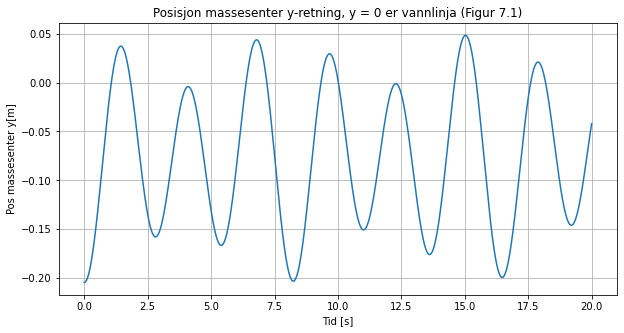

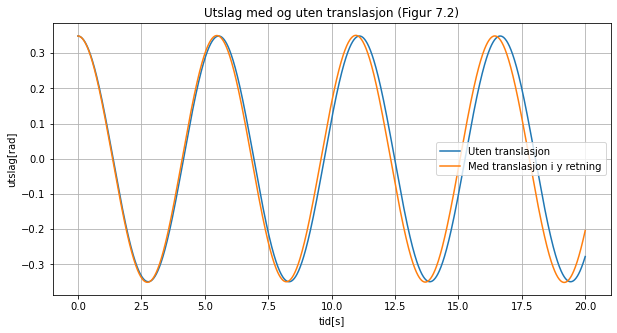

Max utslag i radianer uten translasjon: 0.3490658503988659
Max utslag i radianer med translasjon: 0.3511039906544787


In [13]:
#omega_vec = [theta, omega, y, vy, x, vx]
omega_vec_0 = [20*np.pi / 180, 0, yC_0, 0, 0, 0]
t0 = 0
tend = 20

t_vals, omega_vec = ODE_solver(f,t0, tend, omega_vec_0, 0.01, rk4_method)


plt.figure(figsize = (10,5))
plt.plot(t_vals, omega_vec[:,2])
plt.title("Posisjon massesenter y-retning, y = 0 er vannlinja (Figur 7.1)")
plt.xlabel("Tid [s]")
plt.ylabel("Pos massesenter y[m]")
plt.grid(True)
plt.show()

plt.figure(figsize = (10,5))
plt.title('Utslag med og uten translasjon (Figur 7.2)')
plt.plot(t_vals, y_vals[:,0], label='Uten translasjon')
plt.plot(t_vals, omega_vec[:,0], label='Med translasjon i y retning')
plt.xlabel('tid[s]')
plt.ylabel('utslag[rad]')
#plt.xlim(15, 17.5)
#plt.ylim(0.3, 0.4)
plt.grid(True)
plt.legend()
plt.show()

print(f'Max utslag i radianer uten translasjon: {np.max(np.abs(y_vals[:,0]))}')
print(f'Max utslag i radianer med translasjon: {np.max(np.abs(omega_vec[:,0]))}')

In [14]:
yC_max = np.max(omega_vec[:,2])
yC_min = np.min(omega_vec[:,2])

print(f"Den høyeste verdien av yC er {yC_max} m")
print(f"Den laveste verdien av yC er {yC_min} m")

idx_max = np.argwhere(omega_vec[:,2] == yC_max)
idx_min = np.argwhere(omega_vec[:,2] == yC_min)

theta_yCmax = omega_vec[idx_max,0]
theta_yCmin = omega_vec[idx_min,0]

gamma_max = 2 * np.arccos(np.cos(beta/2) - 4/(3 * np.pi) * (1 - np.cos(theta_yCmax)) + (yC_max - yC_0) / R) 
gamma_min = 2 * np.arccos(np.cos(beta/2) - 4/(3 * np.pi) * (1 - np.cos(theta_yCmin)) + (yC_min - yC_0) / R) 

print(f"Den største oppdriftskraften er {'{:.3f}'.format(F_B(gamma_min)[0][0])} N")
print(f"Den minste oppdriftskraften er {'{:.3f}'.format(F_B(gamma_max)[0][0])} N")
print(f"Tyngdekraften som virker på båten er {'{:.3f}'.format(m*g)} N")

Den høyeste verdien av yC er 0.04832510566937697 m
Den laveste verdien av yC er -0.2044042626987297 m
Den største oppdriftskraften er 816690.162 N
Den minste oppdriftskraften er 725475.164 N
Tyngdekraften som virker på båten er 770475.598 N


I $\textbf{Figur 7.1}$ har vi plottet hvordan posisjonen til massesenteret $C$ endrer seg når båten settes i en svingebevegelse med $\theta_0 = 20^{\circ}$. I $\textbf{Figur 7.2}$ har vi plottet utslaget sammen med utslaget da vi neglisjerte massesenterets bevegelse. 

Vi ser at amplituden på utslagene til y koordinaten til massesenteret, $y_C$, varierer med tiden. Dette vil si at mengden fortrengtvann vil variere med tiden, og dermed at oppdriftskraften vil variere med tiden. Vi observerer av plottet over at dette medfører at den utregnede vinkelen vil være annerledes med og uten translasjon. Vi observerer også at svingningen vil bli raskere, dette kan begrunnes med at kreftene som virker på båten blir større ved at mer vann fortrenges når båten krenger. Vinkelen til utslaget endres derimot svært lite. 

### $\textbf{9 Kantring}$

Vi skal nå utvide funksjonaliteten til koden til å inkludere muligheten for at skipet kantrer. I dette prosjektet forekommer kantring hvis dekket kommer i kontakt med vannoverflaten. Dette betyr at kriteriet for kantring er $\theta > \frac{\pi-\gamma}{2}$. Når kriteriet for kantring oppfylles settes $\theta$ umiddelbart lik $\pi/2$, noe som gjør det svært enkelt å se hvor båten kantrer i plottene våre. 

Under har vi definert funksjonen **lavest_omega()** som bruker halveringsmetoden til å finne den laveste mulige $\omega_0$ som medfører at båten kantrer. Den tar inn en for høy og en for lav verdi av $\omega$, og sjekker kantring for gjennomsnittet $c$. Hvis båten kantrer med $\omega = c$ settes omega_high $=c$. Ellers settes omega_low $=c$. Prosedyren gjentas helt til differansen mellom de to verdiene for $\omega$ har nådd en gitt toleranse. Med $tol = 10^{-8}$ og $h=0.01$ vil den laveste verdien for $\omega$ som får skipet til å kantre være $\omega \approx 0.433$. 

In [15]:
#sjekker om en båt har kantra
def check_kantre(t_vals, omega_vec):
    N = np.shape(omega_vec)[0]

    for i in range(N):
        gamma = 2 * np.arccos(np.cos(beta/2) - 4/(3 * np.pi) * (1 - np.cos(omega_vec[i][0])) + (omega_vec[i][2] - yC_0) / R)
        if omega_vec[i][0] > 0.5 *(np.pi-gamma):
            return True

    return False

#skal finne lavest mulig omega som gir kantring.
def lavest_omega(f, t0, tend, omega_low, omega_high, tol = 1.e-8, h = 1.e-2):
    t_l, omega_l = ODE_solver(f,t0,tend, np.array([0, omega_low,yC_0,0,0,0]), h, method =rk4_method)
    t_h, omega_h = ODE_solver(f, t0, tend, np.array([0,omega_high,yC_0, 0,0,0]),h,method = rk4_method)


    while (omega_high - omega_low) > tol:
        c = 0.5 * (omega_high + omega_low)

        t_c, omega_c = ODE_solver(f,t0,tend,np.array([0,c,yC_0,0,0,0]),h,method = rk4_method)

        if check_kantre(t_c,omega_c):
            omega_high = c
        else:
            omega_low = c

    return omega_high


print(lavest_omega(f,0,20,0,1))

0.4332522228360176



Skipet har kantret ved t = 12.349999999999781


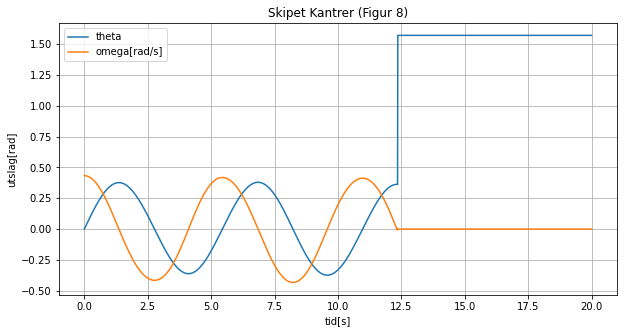

In [16]:
# omega_vec = [theta, omega, y, vy, x, vx]
omega_vec_0 = [0,0.4332522228360176, yC_0, 0, 0, 0]
t0 = 0
tend = 20

#skal sjekke om skipet kantrer
t_vals, omega_vals = ODE_solver(f,t0,tend,omega_vec_0,0.01,rk4_method,check_kantre=True)

plt.figure(figsize = (10,5))
plt.plot(t_vals, omega_vals[:,0], label='theta')
plt.plot(t_vals, omega_vals[:,1], label='omega[rad/s]')
plt.title('Skipet Kantrer (Figur 8)')
plt.xlabel('tid[s]')
plt.ylabel('utslag[rad]')
plt.legend()
plt.grid(True)
plt.show()

I $\textbf{Figur 8}$ over har vi plottet bevegelsen til båten med $\omega_0 = 0.4332522228360176$. Fra figuren ser en veldig enkelt hvordan båten kantrer ved $t\approx12.35s$

### $\textbf{10 Last}$

Videre antar vi at skipet har med en last $m_L$, som vi for enkelhets skyld behandler som en punktpartikkel. Vi antar videre at våre svenske seilere har glemt å feste lasten, slik at den beveger seg fritt på dekk. For enkelhetens skyld ser vi bort i fra friksjonen mellom dekket og lasten. 

Det er hensiktsmessig å kun bruke lastens posisjon relativt til metasenteret, $s_L$, slik at når $s_L = \pm R$ så er lasten lengst mulig til høyre (vestre) på dekk. 
Lastens hastighet er: 

$v_L = \frac{\partial s_L}{\partial t}$

For å finne ut av hvordan lasten beveger seg på dekk må vi se på kreftene som virker. Kreftene som virker på båten er tyngdekraften og normalkraften fra båten. Vi forenkler systemet slik at normalkraften er lik uavhengig av vinkelakkselerasjonen. Når båten har rotert til en vinkel $\theta$ vil dekket ha en vinkel $\theta$. Tyngdekraften vil alltid virke rett nedover, og komponenten av tyngdekraften som virker på lasten langs dekket vil være $-m_L g \sin{\theta}$. Dette vil være den eneste kraften som virker langs dekket. Normalkraften og komponenten av tyngdekraften som virker ortogonalt på  dekket vil kansellere hverandre slik at den eneste kraften som fører til at lasten beveger seg er komponenten av tyngdekraften som har retning langs dekket. Dette gir oss

$\frac{d v_{s_L}}{d t} = - g \sin{\theta}$


I tillegg til at lasten har si egen dynamikk som styres av $\theta$, påvirker den også dynamikken til skipet.
- $m \rightarrow m + m_L$ som medfører at likevektsstørrelsene ($\beta$, $A_0$, etc) må beregnes på nytt. 
- lasten skaper et dreiemoment $\tau_L$

**(15d)** $\tau_L = - m_L g \cos(\theta) s_L$

- skipet blir utsatt for kreftene

**(14f)** $F_L^x = m_L g \cos{\theta} \sin{\theta}$

**(14e)** $F_L^y = - m_L g \cos^2{\theta}$


Dette gjør at:

$\sum F_x = F_L^x$

$\sum F_y = F_B + F_G + F_L^y$

$\sum \tau = \tau_B + \tau_L$

In [17]:
#må finne nye verdier for [beta, yc] osv når vi legger til last
#returnerer [beta, A0, yC0, yM0, yD0, yB0]
def initVals_last(mL):
    sigma_L = sigma + mL / As
    g = lambda beta: np.pi * sigma_L / sigma0 + np.sin(beta)
    f = lambda beta: beta - g(beta)

    beta, it = solve_fixedpoint(f,g,1)

    yM_0 = R*np.cos(beta/2)
    yC_0 = R*np.cos(beta/2) - 4*R / (3*np.pi)
    yD_0 = R*np.cos(beta/2) - R
    yB_0 = R*np.cos(beta/2) - 4 * R * (np.sin(beta/2))**3 / (3 * (beta - np.sin(beta)))

    A0 = 0.5* R**2 *(beta- np.sin(beta))

    return [beta, A0,yC_0, yM_0, yD_0,yB_0]

#de nye dreiemomentene og kreftene
def tau_L(mL, theta, sL):
    return - mL * g * np.cos(theta) * np.abs(sL)

def FL_x(mL, theta):
    return mL * g * np.cos(theta) * np.sin(theta)

def FL_y(mL, theta):
    return - mL * g * (np.cos(theta))**2

#tar med kreftene fra lasten
#omega_vec = [theta, omega, y, vy, x, vx, sL, vsL]
def f_last(t, omega_vec, mL):
    theta = omega_vec[0]
    omega = omega_vec[1]
    y = omega_vec[2]
    vy = omega_vec[3]
    x = omega_vec[4]
    vx = omega_vec[5]
    sL = omega_vec[6]
    vsL = omega_vec[7]

    gamma = 2 * np.arccos(np.cos(beta/2) - 4/(3 * np.pi) * (1 - np.cos(theta)) + (y - yC_0) / R)

    return np.array([omega, 
    (- F_B(gamma) * h * np.sin(theta) + tau_L(mL, theta, sL))/(I_C+ mL *np.sqrt(h**2 + sL**2)**2 ), 
    vy, 
    (F_B(gamma) - As * sigma * g)/(m + mL) + FL_y(mL, theta)/(mL + m), 
    vx, 
    FL_x(mL, theta)/(mL+m), 
    vsL, 
    -g * np.sin(theta)])


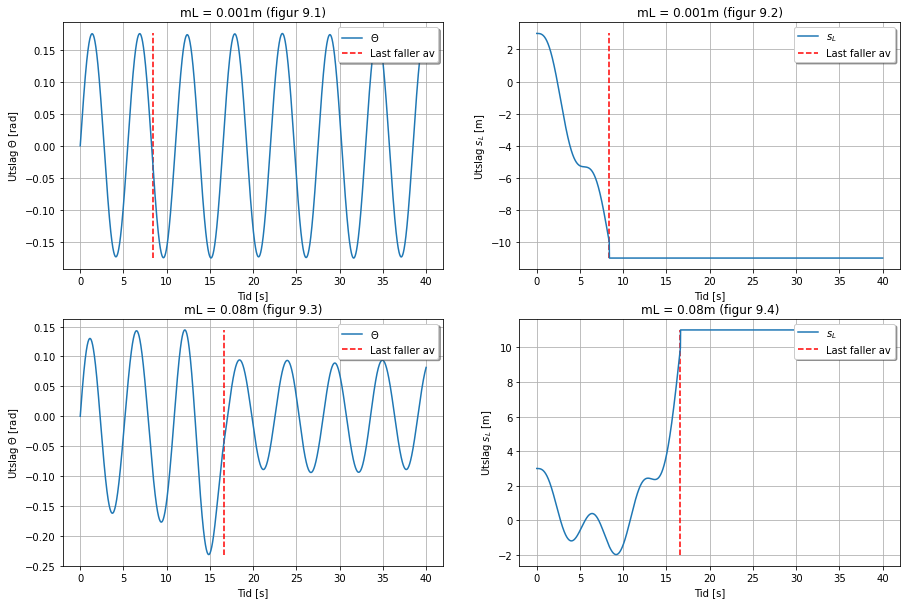

In [18]:
#mL = 0.001m, finner de nye initialverdiene
mL = 0.001

initVals = initVals_last(mL)

t_vals1, omega_vals1 = ODE_solver(f_last,0,40,np.array([0,0.2,initVals[2],0,0,0,3,0]),0.01,rk4_method, mL = mL, check_kantre=True, fence = False, check_last=True)

#finner punktet der hvor lasten faller av
idx1 = np.argwhere(abs(omega_vals1[:,6]) > R)[0]



#mL = 0.08, finner de nye initialverdiene
mL = 0.08*m

initVals = initVals_last(mL)

t_vals2, omega_vals2 = ODE_solver(f_last,0,40,np.array([0,0.2,initVals[2],0,0,0,3,0]),0.01,rk4_method, mL = mL, check_kantre=True, fence = False, check_last=True)

#finner punktet der hvor lasten faller av
idx2 = np.argwhere(abs(omega_vals2[:,6]) > R)[0]

#plotter figuren. 
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.title("mL = 0.001m (figur 9.1)")
plt.plot(t_vals1, omega_vals1[:,0], label = '$\Theta$')
plt.vlines([t_vals[idx1]], np.min(omega_vals1[:,0]), np.max(omega_vals1[:,0]),colors = 'red', linestyles='dashed', label = "Last faller av")
plt.ylabel('Utslag $\Theta$ [rad]')
plt.xlabel('Tid [s]')
plt.grid(True)
plt.legend(fancybox = True, shadow = True, loc ="upper right")

plt.subplot(2,2,2)
plt.title("mL = 0.001m (figur 9.2)")
plt.plot(t_vals1, omega_vals1[:,6], label = '$s_L$')
plt.vlines([t_vals[idx1]], np.min(omega_vals1[:,6]), np.max(omega_vals1[:,6]),colors = 'red', linestyles='dashed', label = "Last faller av")
plt.ylabel('Utslag $s_L$ [m]')
plt.xlabel('Tid [s]')
plt.grid(True)
plt.legend(fancybox = True, shadow = True, loc ="upper right")


plt.subplot(2,2,3)
plt.title("mL = 0.08m (figur 9.3)")
plt.plot(t_vals2, omega_vals2[:,0], label = '$\Theta$')
plt.vlines([t_vals[idx2]], np.min(omega_vals2[:,0]), np.max(omega_vals2[:,0]),colors = 'red', linestyles='dashed', label = "Last faller av")
plt.ylabel('Utslag $\Theta$ [rad]')
plt.xlabel('Tid [s]')
plt.grid(True)
plt.legend(fancybox = True, shadow = True, loc ="upper right")

plt.subplot(2,2,4)
plt.title("mL = 0.08m (figur 9.4)")
plt.plot(t_vals2, omega_vals2[:,6], label = '$s_L$')
plt.vlines([t_vals[idx2]], np.min(omega_vals2[:,6]), np.max(omega_vals2[:,6]),colors = 'red', linestyles='dashed', label = "Last faller av")
plt.ylabel('Utslag $s_L$ [m]')
plt.xlabel('Tid [s]')
plt.grid(True)
plt.legend(fancybox = True, shadow = True, loc ="upper right")

plt.show()

I figuren ovenfor $\textbf{(Figur 9)}$ er $\theta$ og $s_L$ plottet som funksjon av tid. De to øverste plottene tilhører en last med masse $m_L = 0.001 m$, mens det nederste tilhører en last med masse $m_L = 0.08 m$. I begge plottene er lastene plassert ved $s_L = 3$m ved $t = 0$. Videre har begge en vinkelfart $\omega = 0.4$rad/s ved $t= 0$, og alle likevektsverdiene er beregna på nytt med hensyn på lasten.

En kan observere at lasten med masse $m_L = 0.001m$ har liten påvirkning på båtens dynamikk. Etter at lasten har falt av fortsetter båten mer eller mindre og oscillere med lik amplitude og lik frekvens. Dette er et rimelig resultat da massen til lasten er liten i forhold til skipets masse, kun $0.1$% av massen til båten.

I motsetning vil lasten med masse $m_L = 0.08 m$ påvirke skipet mye. Før lasten faller av ser vi at den bidrar til økt amplitude på vinkelutslaget $\theta$. Vi ser også at den vil oscillere rundt meta senteret, $s_L = 0$, før den til slutt faller av. Når den oscillerer rundt $s_L = 0$ har den relativt små utslag, under 2m. Vi ser at frekvensen til denne oscillasjonen er ganske lik frekvensen til båten, dette skaper resonans som forklarer hvorfor amplituden til $\theta$ øker. Etter at lasten har falt av vil utslagene til $\theta$ bli betydelig mindre. Dette er fordi lasten tar med seg en del energi når den faller av.

En kan observere at lasten med lavest masse faller av båten tidligere enn lasten med høyest masse. Dette er et rimelig resultat da det skal mindre til for å bevege en lav masse enn en høy masse.

<Figure size 1080x720 with 0 Axes>

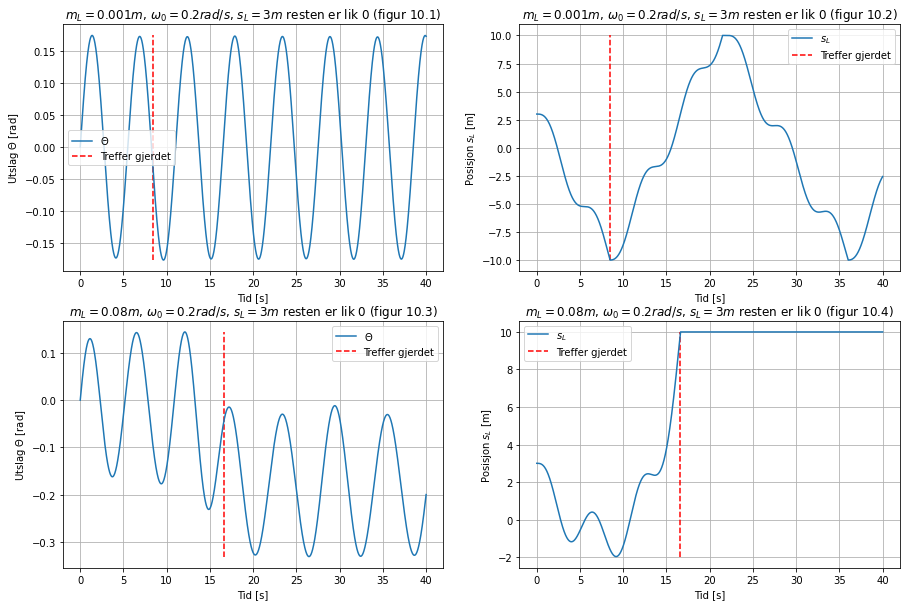

In [19]:
#mL = 0.001, finner de nye initialverdiene
mL = 0.001*m

initVals = initVals_last(mL)

t_vals1, omega_vals1 = ODE_solver(f_last,0,40,np.array([0,0.2,initVals[2],0,0,0,3,0]),1.e-2,rk4_method,mL = mL,check_kantre=True,check_last=True,fence=True)

plt.figure(figsize = (15,10))

idx1 = np.argwhere(abs(omega_vals1[:,6]) == R)[0]


#mL = 0.08, finner de nye initialverdiene
mL = 0.08*m

initVals = initVals_last(mL)

t_vals2, omega_vals2 = ODE_solver(f_last,0,40,np.array([0,0.2,initVals[2],0,0,0,3,0]),1.e-2,rk4_method,mL = mL,check_kantre=True,check_last=True,fence=True)

plt.figure(figsize = (15,10))

idx2 = np.argwhere(abs(omega_vals2[:,6]) == R)[0]


plt.subplot(2,2,1)
plt.title("$m_L = 0.001m$, $\omega_0 = 0.2 rad/s$, $s_L = 3m$ resten er lik 0 (figur 10.1)")
plt.plot(t_vals1, omega_vals1[:,0], label = "$\Theta$")
plt.xlabel("Tid [s]")
plt.ylabel("Utslag $\Theta$ [rad]")
plt.vlines([t_vals[idx1]], np.min(omega_vals1[:,0]), np.max(omega_vals1[:,0]), colors= 'red', linestyles='dashed', label = 'Treffer gjerdet')
plt.grid(True)
plt.legend()

plt.subplot(2,2,2)
plt.title("$m_L = 0.001m$, $\omega_0 = 0.2 rad/s$, $s_L = 3m$ resten er lik 0 (figur 10.2)")
plt.plot(t_vals1, omega_vals1[:,6], label = "$s_L$")
plt.xlabel("Tid [s]")
plt.ylabel("Posisjon $s_L$ [m]")
plt.vlines([t_vals[idx1]], np.min(omega_vals1[:,6]), np.max(omega_vals1[:,6]), colors= 'red', linestyles='dashed', label = 'Treffer gjerdet')
plt.grid(True)
plt.legend()

plt.subplot(2,2,3)
plt.title("$m_L = 0.08m$, $\omega_0 = 0.2 rad/s$, $s_L = 3m$ resten er lik 0 (figur 10.3)")
plt.plot(t_vals2, omega_vals2[:,0], label = "$\Theta$")
plt.xlabel("Tid [s]")
plt.ylabel("Utslag $\Theta$ [rad]")
plt.vlines([t_vals[idx2]], np.min(omega_vals2[:,0]), np.max(omega_vals2[:,0]), colors= 'red', linestyles='dashed', label = 'Treffer gjerdet')
plt.grid(True)
plt.legend()

plt.subplot(2,2,4)
plt.title("$m_L = 0.08m$, $\omega_0 = 0.2 rad/s$, $s_L = 3m$ resten er lik 0 (figur 10.4)")
plt.plot(t_vals2, omega_vals2[:,6], label = "$s_L$")
plt.xlabel("Tid [s]")
plt.ylabel("Posisjon $s_L$ [m]")
plt.vlines([t_vals[idx2]], np.min(omega_vals2[:,6]), np.max(omega_vals2[:,6]), colors= 'red', linestyles='dashed', label = 'Treffer gjerdet')
plt.grid(True)
plt.legend()

plt.show()


De fleste båter har gjerder for å for å hindre at lasten faller av. I modellen vår neglisjerer vi kraften som overføres fra lasten til gjerdet. I figur **10.1** og **10.2** ser vi på hva som skjer med dynamikken til båten når vi har en last med masse $m_L = 0.001m$ og med ininitalverdiene $\omega_0 = 0.2 rad/s$ og $s_L = 3m$, mens i figur **10.3** og **10.4** ser vi på en last med masse $m_L = 0.08m$ med de samme initialverdiene. En kan observere at dynamikken er lik den som er i figurene **9.1** - **9.4**, før lasten faller av i disse. Nå vil ikke lasten falle av lenger, men den vil heller bli stoppet av gjerdet.

For lasten med størst masse ser vi fra figur **10.3** at $\theta < 0$ etter at lasten har blitt truffet av gjerdet. Da har båten fått en permanent slagside. Videre vil ikke amplituden falle når lasten treffer gjerdet, som det gjorde når lasten faller av. Dette er fordi lasten tar med seg energi når den faller av. Videre ser vi at lasten vil forbli ved det samme gjerdet resten av tida.

I motsetning til lasten med størst masse vil ikke lasten med lavest masse føre til at båten får en slagside. I figur **10.1** ser vi at båten er tilnærmet upåvirket av lasten når vi har gjerder. Det skjedde uten gjerder som en kan se i figur **9.1**. Videre vil ikke den minste lasten bli værende ved gjerdet, som den største massen vil. Fra figur **10.2** ser vi at lasten vil bevege seg fra gjerde til gjerde.

### $\textbf{11 Ytre krefter}$

Det er nå på tide å se hvordan friksjon, vind og bølger vil påvirke dynamikken til skipet. De to sistnevnte kreftene vil angripe i x-retning, og åpner derfor for at massesenteret også beveger seg i x-retning. Til å begynne med setter vi $F_0 = 0$, og er kun interessert i hvordan friksjonskraften påvirker systemet. Summen av kreftene i x-retning er nå gitt ved: 

$$\sum{F_x} = f \implies \frac{\partial v_x}{\partial t} = \frac{f}{m}$$

Friksjonskraften vil også generere et dreiemoment, noe som gir: 

$$\sum \tau = \tau_B + \tau_f \implies \frac{\partial \omega}{\partial t} = \frac{\tau_B + \tau_f}{I_C}$$

For å se hvordan friksjonskraften påvirker skipsmodellen plotter vi bevegelsen til skipet for ulike verdier av friksjonskoeffesienten $k_f$. Videre vil vi også droppe å ha usikret last på dekk. 

In [20]:
def friction(gamma, omega):
    return -k_f * R * gamma * omega


def Fw(t, omega_w, F0):
    return F0 * np.cos(omega_w*t)

#lambda function
func_w = lambda t : Fw(t,omega_w, F0)

#omega_vec = [theta, omega, y, vy, x, vx, sL, vsL]
def f_tot(t, omega_vec, mL):

    theta = omega_vec[0]
    omega = omega_vec[1]
    y = omega_vec[2]
    vy = omega_vec[3]
    x = omega_vec[4]
    vx = omega_vec[5]
    sL = omega_vec[6]
    vsL = omega_vec[7]

    gamma = 2 * np.arccos(np.cos(beta/2) - 4/(3 * np.pi) * (1 - np.cos(theta)) + (y - yC_0) / R)

    return np.array([
    omega, 
    (- F_B(gamma) * h * np.sin(theta) + tau_L(mL, theta, sL) + friction(gamma, omega) * (y - (R * (np.cos(gamma/2)-1))) + Fw(t, omega_w, F0) * y)/(I_C + mL *np.sqrt(h**2 + sL**2)**2), 
    vy, 
    (F_B(gamma) - As * sigma * g)/(m + mL) + FL_y(mL, theta)/(mL + m), 
    vx, 
    (FL_x(mL, theta) + friction(gamma, omega) + func_w(t))/(mL+m), 
    vsL, 
    -g * np.sin(theta)])


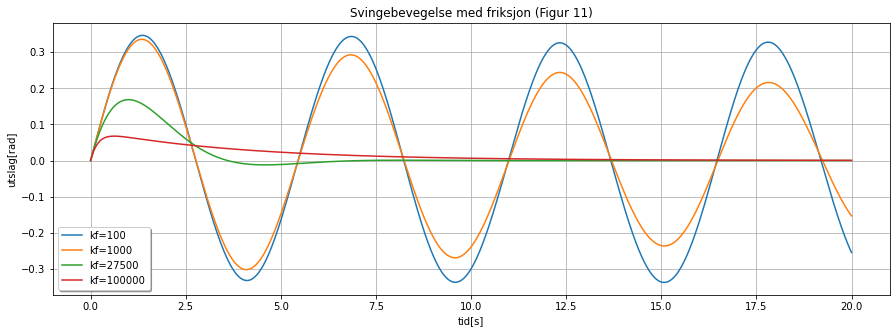

In [21]:
#parametre
k_f = 100 #kg/s
omega_w = 0
F0 = 0
t0 = 0
tend = 20

#initialverdier
omega_vec_0 = np.array([0,0.4,yC_0,0,0,0,0,0])

t_vals1, omega_vec_vals1 = ODE_solver(f_tot,t0,tend,omega_vec_0,0.01,rk4_method,check_kantre=True)

#parametre
k_f = 1000 #kg/s
omega_w = 0
F0 = 0

t_vals2, omega_vec_vals2 = ODE_solver(f_tot,t0,tend,omega_vec_0,0.01,rk4_method,check_kantre=True)

#parametre
k_f = 27500 #kg/s
omega_w = 0
F0 = 0

t_vals3, omega_vec_vals3 = ODE_solver(f_tot,t0,tend,omega_vec_0,0.01,rk4_method,check_kantre=True)

#parametre
k_f = 100000 #kg/s
omega_w = 0
F0 = 0

t_vals4, omega_vec_vals4 = ODE_solver(f_tot,t0,tend,omega_vec_0,0.01,rk4_method,check_kantre=True)

plt.figure(figsize=(15,5))
plt.title('Svingebevegelse med friksjon (Figur 11)')
plt.xlabel('tid[s]')
plt.ylabel('utslag[rad]')
plt.plot(t_vals1, omega_vec_vals1[:,0], label='kf=100')
plt.plot(t_vals2, omega_vec_vals2[:,0], label='kf=1000')
plt.plot(t_vals3, omega_vec_vals3[:,0], label='kf=27500')
plt.plot(t_vals4, omega_vec_vals4[:,0], label='kf=100000')
plt.grid(True)
plt.legend(fancybox = True, shadow = True)
plt.show()

Som en ser fra $\textbf{Figur 11}$ vil friksjonskraften gjøre at vi får dempede svingninger, noe en ser ved at amplituden til vinkelutslaget minker med tiden. I dette tilfellet har vi valgt 4 ulike verdier for friksjonskoeffesienten i forskjellig størrelsesorden, og i plottet kan vi observere hvor utslagsgivende verdien av $k_f$ er. For $k_f = 100 kg/s$ og $k_f = 1000 kg/s$ observerer vi det som kalles underkritisk demping. Her vil det fortsatt være kraften i selve svingebevegelsen som vil være dominerende, og friksjonskraften vil gjøre at amplituden til utslaget gradvis synker i verdi. For $k_f = 27500$ observerer vi det som kalles kritisk demping. Nå matcher friksjonskraften kraften i svingebegevelsen, og vi får kun et lite utsving før båten stabiliserer seg i likevekt. For $k_f = 100000 kg/s$ kan en se at svingebevegelsen er helt borte, og skipet vil sige saktne ned mot likevekt. Dette er hva vi kaller overkritisk demping, og her vil da friksjonskraften være dominerende. 


I motsetning til andre faktorer vi har implementert vil friksjonskraften ikke forverre skipets stabilitet, men istedenfor gjøre at det skal mer til før det kantrer. 

Videre skal vi også inkludere påvirkningen fra vind og bølger. Vi må da igjen utvide bevegelseslikningen vår i x-retning: 

$$\sum{F_x} = f + F_w \implies \frac{\partial v_x }{\partial t} = \frac{f + F_w}{m}$$


$$\sum \tau = \tau_B + \tau_f + \tau_w \implies \frac{\partial \omega}{\partial t} = \frac{\tau_B + \tau_f + \tau_w}{I_C}$$

I dette tilfellet settes $k_f = 100kg/s$

In [22]:
#egenfrekvensen til 
omega0 = np.sqrt(m*g*h/I_C)
print(omega0)

#parametre
k_f = 100 #kg/s
omega_w = 0.93 * omega0 #0.93 * omega0
F0 = 0.625*m*g

#initialbetingelser
omega_vec_0 = np.array([0,2*np.pi / 180, yC_0,0,0,0,0,0])
t0 = 0
tend = 240

#definerer funksjonen med de gitte parametrene
func_w = lambda t: Fw(t,omega_w,F0)

t_vals, omega_vec_vals = ODE_solver(f_tot,t0,tend,omega_vec_0,0.01,rk4_method,check_kantre=True)

1.1408796602332403


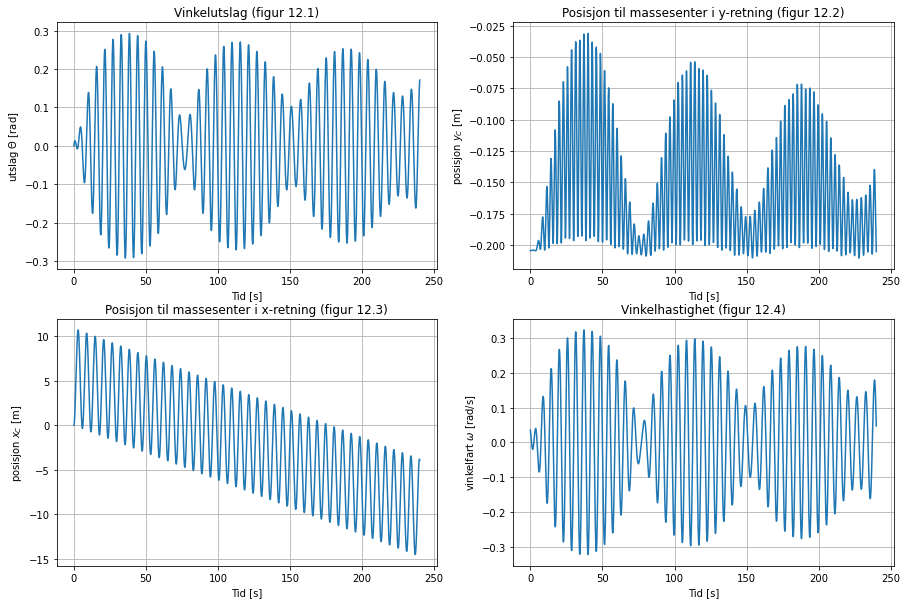

In [23]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.title('Vinkelutslag (figur 12.1)')
plt.plot(t_vals,omega_vec_vals[:,0])
plt.xlabel('Tid [s]')
plt.ylabel('utslag $\Theta$ [rad]')
plt.grid(True)

plt.subplot(2,2,2)
plt.title('Posisjon til massesenter i y-retning (figur 12.2)')
plt.plot(t_vals,omega_vec_vals[:,2])
plt.xlabel('Tid [s]')
plt.ylabel('posisjon $y_C$ [m]')
plt.grid(True)

plt.subplot(2,2,3)
plt.title('Posisjon til massesenter i x-retning (figur 12.3)')
plt.plot(t_vals,omega_vec_vals[:,4])
plt.xlabel('Tid [s]')
plt.ylabel('posisjon $x_C$ [m]')
plt.grid(True)

plt.subplot(2,2,4)
plt.title('Vinkelhastighet (figur 12.4)')
plt.plot(t_vals,omega_vec_vals[:,1])
plt.xlabel('Tid [s]')
plt.ylabel('vinkelfart $\omega$ [rad/s]')
plt.grid(True)

plt.show()

Fra figuren over $\textbf{Figur 12}$ ser vi på hva som skjer når vinden og bølgende har vinkelfart lik $\omega_w = 0.93 \omega_0$, der $\omega_0 \approx 1.1408796602332403$ er resonans vinkelfarten til skipet. Det vi ser her er at vinkelen $\theta$ til skipet oscillerer med en fast periode, mens amplituden til utslagene oscillerer med en annen gitt periode. Dette fenomenet kalles svevning.Sveving oppstår når vi har to harmoniske svingninger med veldig lik frekvens, men ikke helt lik. I dette tilfellet er det frekvensen til vinden og bølgene som er litt ulik ressonansfrekvensen til båten.Det samme fenomenet vil forekomme for vinkelfarten $\omega$. Dreiemomentet som $F_w$ genererer om $C$ er da ikke samkjørt med dreiemomentet som $F_B$ genererer om $C$. Vil vil da ha noen perioder der de to bidragene roterer båten i samme retning, og andre perioder der de motvirker hverandre. 

Vi ser igjen hvordan friksjonskraften demper svingningene. I dette plottet kan en også se hvordan vind og bølger skaper bevegelse i x-retning. Fra plottet ser det ut til at skipet driver mot venstre samtidig som det beveger seg periodisk fram og tilbake. Sistnevnte skyldes åpenbart den periodiske kraften $F_w$. Skipet driver mot venstre fordi båtens svingebevegelse og den harmoniske kraften $F_w$ ikke er samstemte. Dette betyr at vinden og bølgene vil få varierende "konkurranse" fra friksjonskraften. Friksjonskraften varierer dessuten kun som en funksjon av vinkelhastigheten $w$ og ikke av translasjonshastigheten $v_x$. 

### $\textbf{12 Resonans med ulike løsere}$

**Adaptive metoder:**

En fordel med adaptive løsere er at de kan variere steglengden avhengig av hvordan funksjonen endrer seg. Dersom funksjonen endrer seg mye vil den adaptive løseren gjøre steglengden mindre slik at den får med seg all informasjonen. Hvor lang denne steglengden er bestemmes av toleransen som er bestemt av brukeren. 

**Implisitte metoder:**

Implisitte metoder er metoder som ikke bare bruker forrige men som også bruker den deriverte på det nye steget når man skal regne seg frem til neste verdi. Fordelen med implisitte metoder er at de kan brukes til å løse stive differensial likninger. Dette medfører at man må løse den implisitte likningen. Dette gjør at metodene er treigere, og lite gunstig å bruke hvis man ikke skal løse en stiv difflikning. Radau er en implisitt, adaptiv metode. 

**Scipy Biblioteket:**

Innebygd i scipy biblioteket er det implementert flere ODE-løsere, blant annet DOP853, RK45 og Radau. Alle disse er runge-kutta metoder, men de har ulike ordener og Radau er en implisitt metode mens de andre er eksplisitte. Ordenen til DOP853 er 8(5,3), orden til RK45 er 5(4) og ordenen til Radau er 5. Den implisitte metoden Radau er god til å løse problemer med stive differensial likninger. Vi ønsker å sammenlikne disse løserne med runge-kutta 4 metoden som vi har implementert og brukt tidligere, ved å se på hva som skjer med båten når frekvensen til vind og bølger er lik båtens egenfrekvens.

I scipy metodene kan man sette parameterne atol og rtol, disse bestemmer toleransen i de adaptive metodene. Vi har valgt $atol = 10^{-8}$ og $rtol = 10^{-8}$, der det lokale feilestimatet $\lvert le_{n+1} \rvert \leq atol + rtol \lvert y \rvert$. Standarden for ODE løseren er $atol = 10^{-6}$ og $rtol = 10^{-3}$. Vi bruker disse verdiene for atol og rtol for å sammenlikne med RK4-metoden med steglengde $h=10^{-2}$, som vil ha en global feil $\lvert e_N \rvert$ som oppfyller $\lvert e_N \rvert \leq C 10^{-8}$.

/Users/sondredahl/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py:502: RuntimeWarning: invalid value encountered in double_scalars
  return np.abs(h) * err5_norm_2 / np.sqrt(denom * len(scale))



Skipet har kantret ved t = 124.76000000002692
RK45 kantrer ved t = 124.7616279617747
DOP853 kantrer ved t = 124.76162801014776

Radau kantrer ved t = 124.76162652934616
-------------------------------------------------
Runtime rk45 = 0.6664659976959229
Runtime dop853 = 0.31925129890441895
Runtime rk4(0.01) = 6.130231857299805
Runtime radau = 3.160806179046631


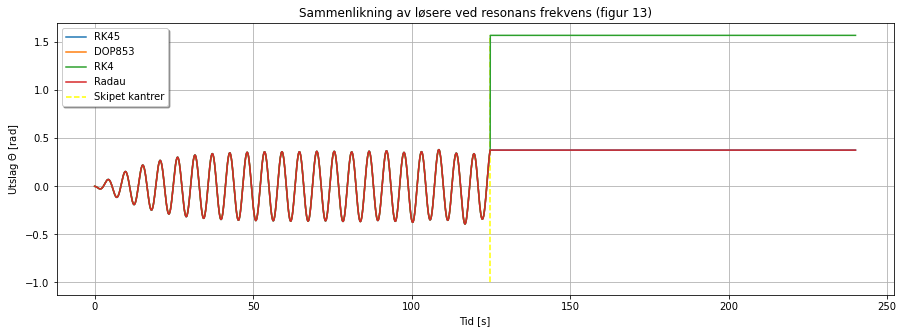

In [27]:
def first_kantret(t_vals, theta_vals, yc_vals):
    N = len(theta_vals)

    for i in range(N):
        gamma = 2 * np.arccos(np.cos(beta/2) - 4/(3 * np.pi) * (1 - np.cos(theta_vals[i])) + (yc_vals[i] - yC_0) / R)
        if theta_vals[i] > 0.5 *(np.pi-gamma):
            return t_vals[i]

    return t_vals[-1]


def f_tot(t, omega_vec, mL):

    theta = omega_vec[0]
    omega = omega_vec[1]
    y = omega_vec[2]
    vy = omega_vec[3]
    x = omega_vec[4]
    vx = omega_vec[5]
    sL = omega_vec[6]
    vsL = omega_vec[7]

    gamma = 2 * np.arccos(np.cos(beta/2) - 4/(3 * np.pi) * (1 - np.cos(theta)) + (y - yC_0) / R)

    if theta > (np.pi - gamma) / 2:
        sgn = omega_vec[0] / abs(omega_vec[0])

        omega_vec = np.zeros(8)
        omega_vec[0] = sgn*np.pi/2

        return np.array([0,0,0,0,0,0,0,0])
    
    return np.array([
    omega, 
    (- F_B(gamma) * h * np.sin(theta) + tau_L(mL, theta, sL) + friction(gamma, omega) * (y - (R * (np.cos(gamma/2)-1))) + Fw(t, omega_w, F0) * y)/(I_C + mL *np.sqrt(h**2 + sL**2)**2), 
    vy, 
    (F_B(gamma) - As * sigma * g)/(m + mL) + FL_y(mL, theta)/(mL + m), 
    vx, 
    (FL_x(mL, theta) + friction(gamma, omega) + func_w(t))/(mL+m), 
    vsL, 
    -g * np.sin(theta)])


#Modify f_tot to work here (f can only take two arguments with solve_ivp): 
f_tot_modified = lambda t, omega_vec :f_tot(t,omega_vec,0)

#With scipy: 
from scipy import integrate

def scipy_method(f, t0, t_end, omega_vec_0, method = 'RK45', atol = 1.e-6, rtol =1.e-3):
    t_span = [t0, t_end]


    '''
    Methods: 
    RK45 (explicit runge kutta method)
    RK23 (explicit runge kutta method)
    DOP853 (explicit runge kutta method of order 8)
    Radau (Implicit runge kutta method of order 5)
    BDF (Implicit multi-step variable-order method)
    LSODA
    '''

    #Note: f can only have two arguments: t & y
    solution = integrate.solve_ivp(f, t_span, omega_vec_0, method, rtol=rtol, atol = atol) #solve_ivp accepts several methods. 
    return solution,solution.t


#parametre
t0 = 0
tend = 240
kf = 1000
F0 = 0.625*m*g
omega_w = omega0

start1 = time.time()
solution_rk45 , t_vals_rk45 = scipy_method(f_tot_modified, t0, tend, np.array([0,0,yC_0,0,0,0,0,0]), atol = 1.e-8, rtol =1.e-8)
end1 = time.time()



start2 = time.time()
solution_dop853, t_vals_dop853 = scipy_method(f_tot_modified, t0, tend, np.array([0,0,yC_0,0,0,0,0,0]), method = 'DOP853',atol = 1.e-8, rtol =1.e-8)
end2 = time.time()




start3 = time.time()
t_vals_rk4, omega_vec_rk4 = ODE_solver(f_tot,t0,tend,np.array([0,0,yC_0,0,0,0,0,0]),0.01,rk4_method, check_kantre=True)
end3 = time.time()



start4 = time.time()
solution_radau, t_vals_radau = scipy_method(f_tot_modified,t0,tend,np.array([0,0,yC_0,0,0,0,0,0]), method = 'Radau',atol = 1.e-8, rtol =1.e-8)
end4 = time.time()




theta_rk45 = solution_rk45.y[0]
theta_dop853 = solution_dop853.y[0]
theta_radau = solution_radau.y[0]

print(f"RK45 kantrer ved t = {first_kantret(t_vals_rk45, theta_rk45, solution_rk45.y[2])}")
print(f"DOP853 kantrer ved t = {first_kantret(t_vals_dop853, theta_dop853, solution_dop853.y[2])}\n")
print(f"Radau kantrer ved t = {first_kantret(t_vals_radau, theta_radau, solution_radau.y[2])}")
print('-------------------------------------------------')
print("Runtime rk45 = %s" % (end1 - start1))
print("Runtime dop853 = %s" % (end2 - start2))
print("Runtime rk4(h=0.01) = %s" % (end3 - start3))
print("Runtime radau = %s" % (end4 - start4))

plt.figure(figsize = (15,5))
plt.title("Sammenlikning av løsere ved resonans frekvens (figur 13)")

#plotter de ulike løsningene
plt.plot(t_vals_rk45, theta_rk45, label = 'RK45')
plt.plot(t_vals_dop853, theta_dop853, label = 'DOP853')
plt.plot(t_vals_rk4, omega_vec_rk4[:,0], label = 'RK4')
plt.plot(t_vals_radau, theta_radau, label = "Radau")

#linja som indikerer at skipet har kantra
plt.vlines([first_kantret(t_vals_dop853, theta_dop853, solution_dop853.y[2])], -1,np.pi/2,colors = 'yellow', linestyles='dashed', label="Skipet kantrer")
plt.grid(True)
plt.xlabel("Tid [s]")
plt.ylabel("Utslag $\Theta$ [rad]")
plt.legend(fancybox = True, shadow = True)
plt.show()

I $\textbf{figur 13}$ ser vi på dynamikken til båten når vi starter med en båt i ro, vinden og bølgene har frekvens lik resonansfrekvens. Vi har satt amplituden til bølgekraften lik $F_0 = 0.625 mg$ og friksjonskoeffisientent $k_f = 1000 kg/s$. Det som skjer er at amplituden til utslagene $\theta$ øker med tiden, til båten tilslutt kantrer. Her er $\theta_0$ og $\omega_0$ lik 0.  

I motsetning til hva vi så i $\textbf{figur 12}$ vil nå dreiemomentbidragene om $C$ være i fase, og vi får dermed en stigende amplitude på utslaget i motsetning til svevningen vi så lenger opp. 

atol = 10^-8, rtol = 10^-8; Radau bruker N = 4307 steg
atol = 10^-8, rtol = 10^-8; RK45 bruker N = 1481 steg
atol = 10^-8, rtol = 10^-8; DOP853 bruker N = 326 steg
RK4 ved h = 0.01 bruker N = 24001 steg


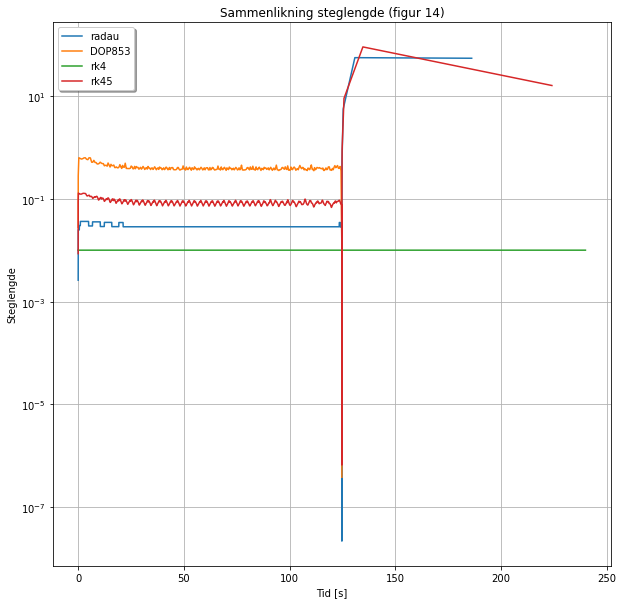

In [28]:
plt.figure(figsize = (10,10))

print(f"atol = 10^{-8}, rtol = 10^{-8}; Radau bruker N = {len(t_vals_radau)} steg")
print(f"atol = 10^{-8}, rtol = 10^{-8}; RK45 bruker N = {len(t_vals_rk45)} steg")
print(f"atol = 10^{-8}, rtol = 10^{-8}; DOP853 bruker N = {len(t_vals_dop853)} steg")
print(f"RK4 ved h = 0.01 bruker N = {len(t_vals_rk4)} steg")

plt.title("Sammenlikning steglengde (figur 14)")
plt.plot(t_vals_radau[:-1], np.diff(t_vals_radau), label = 'radau')
plt.plot(t_vals_dop853[:-1], np.diff(t_vals_dop853), label = 'DOP853')
plt.plot(t_vals_rk4[:-1], np.diff(t_vals_rk4), label = 'rk4')
plt.plot(t_vals_rk45[:-1], np.diff(t_vals_rk45), label = 'rk45')
plt.grid(True)
plt.legend(fancybox = True, shadow = True)
plt.xlabel('Tid [s]')
plt.ylabel('Steglengde')
plt.yscale('log')
plt.show()

Vi observerer i $\textbf{Figur 14}$ at rk4 har den korteste steglengden, fulgt av radau og rk45. Med høyest steglengde har vi DOP853. Dette er i samsvar med våre forventninger ettersom DOP853 er av høyest orden. Vi observerer av steglengde plottet at den adaptive egenskapen ikke påvirker løsningen i nevneverdig grad. Dette plottet viser at det er lite bruk for den adaptive egenskapen, ettersom steglengden ikke endres veldig mye. Rk4 er derfor en svært god metode på dette problemet og er også lett å implementere. De adaptive metoden legger til mye overhead som på dette problemet gir begrenset gevinst. Videre har vi at den implisitte metoden radau legger til enda mer overhead da difflikningen ikke er stiv, og dette observerer vi av runtimen til radau. Merk at vi plotter rk4 også etter båten har kantret, og dette er åpenbart ikke nødvendig, og rk4 runtime vil derfor egentlig være nærmest halvert. Vi observerer at etter båten har kantret slår den adaptive egenskapen svært kraftig inn. Dette synliggjør styrken til de adaptive metodene, ettersom de forstår at løsningen ikke kommer til å endre seg. 

### $\textbf{13 Konklusjon}$

Vi har i dette prosjektet sett på hvordan ulike krefter kan påvirke dynamikken og dermed også stabiliteten til et skip. For å realisere dette har vi løst de koblede differensiallikningene **(12)** og **(13)**, og sammenliknet båtens bevegelse for ulike situasjoner med ulike krefter i spill. Vi har i størst grad tatt i bruk metoden RK4, som med steglengden $h=0.01$ har gitt plausible resultater gjennom oppgaven. Denne metoden har også vist seg å være svært lett å implementere. 

Ustabiliteten til skipet manifesterer seg ved at det gynger frem og tilbake. Dette betyr at skipet har fungert som en fysisk pendel. På grunn av dette har vi gjennom arbeidet med dette prosjektet observert flere fenomener som vi kjenner igjen fra fysikken rundt svingninger, som svevning, resonans og dempede svingninger. Vi har også observert hvordan løs last på dekk vil påvirke skipets dynamikk, der økende masse ikke overraskende ga større påvirkning, og båten fikk en permanent slagside. 

Utifra hva vi har sett gjennom prosjektet, kan vi konkludere med at skipets stabilitet påvirkes mest av løst last, bølger og vind. Dette stemmer meget godt med hva en ser i virkelige situasjoner der stabiliteten til et skip forverres. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=95143714-201c-4af4-b8de-63ba56a9a4c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>